In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

## Explore the dataset

I use pandas for performance and interoffice sharing. I could very easily implement all of the below code using csv readers, strings + lists, etc - but I have found that sharing DFs is simply easier. Especially when some quants use R and Julia, etc. Doing the processing and analysis with a more manual implementation could potentially have certain performance advantages depending on exact implementation, but I generally think Pandas forces me to write cleaner and more precise code - which allows another quant to make adjustments easily without digging too far into deeply nested loops and function calls.  

In [2]:
sample_df = pd.read_csv('data/turnstile_130803.txt', header=None)
# sample_df.head()
sample_df[0:7] # Use to show first known row with NaN

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,A002,R051,02-00-00,07-27-13,00:00:00,REGULAR,4209603,1443585,07-27-13,04:00:00,...,07-28-13,00:00:00,REGULAR,4210432,1443801,07-28-13,04:00:00,REGULAR,4210472,1443805
1,A002,R051,02-00-00,07-28-13,08:00:00,REGULAR,4210490,1443821,07-28-13,12:00:00,...,07-29-13,08:00:00,REGULAR,4211176,1444042,07-29-13,12:00:00,REGULAR,4211350,1444247
2,A002,R051,02-00-00,07-29-13,16:00:00,REGULAR,4211586,1444302,07-29-13,20:00:00,...,07-30-13,14:01:00,DOOR OPEN,4213192,1444700,07-30-13,14:01:35,DOOR OPEN,4213192,1444700
3,A002,R051,02-00-00,07-30-13,14:01:46,LOGON,4213192,1444700,07-30-13,14:01:49,...,07-30-13,14:07:55,DOOR OPEN,4213192,1444700,07-30-13,14:11:56,DOOR CLOSE,4213192,1444700
4,A002,R051,02-00-00,07-30-13,16:00:00,REGULAR,4213333,1444737,07-30-13,20:00:00,...,07-31-13,16:00:00,REGULAR,4214863,1445194,07-31-13,20:00:00,REGULAR,4215656,1445251
5,A002,R051,02-00-00,08-01-13,00:00:00,REGULAR,4215894,1445274,08-01-13,04:00:00,...,08-02-13,00:00:00,REGULAR,4217489,1445773,08-02-13,04:00:00,REGULAR,4217532,1445775
6,A002,R051,02-00-00,08-02-13,08:00:00,REGULAR,4217563,1445856,08-02-13,12:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Confirm for NaN values

In [3]:
sample_df.isnull().any()

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8      True
9      True
10     True
11     True
12     True
13     True
14     True
15     True
16     True
17     True
18     True
19     True
20     True
21     True
22     True
23     True
24     True
25     True
26     True
27     True
28     True
29     True
30     True
31     True
32     True
33     True
34     True
35     True
36     True
37     True
38     True
39     True
40     True
41     True
42     True
dtype: bool

So no col names, and we can see that the 6th row has NaN data. At least some rows have NaN after the 7th col. Let's explore the description fields for more info. This data is from before 10/18/2014 so we will use that one.

In [4]:
print(open('data/ts_Field_Description_pre-10-18-2014.txt').read())

Field Description

C/A,UNIT,SCP,DATE1,TIME1,DESC1,ENTRIES1,EXITS1,DATE2,TIME2,DESC2,ENTRIES2,EXITS2,DATE3,TIME3,DESC3,ENTRIES3,EXITS3,DATE4,TIME4,DESC4,ENTRIES4,EXITS4,DATE5,TIME5,DESC5,ENTRIES5,EXITS5,DATE6,TIME6,DESC6,ENTRIES6,EXITS6,DATE7,TIME7,DESC7,ENTRIES7,EXITS7,DATE8,TIME8,DESC8,ENTRIES8,EXITS8


C/A = Control Area (A002)
UNIT = Remote Unit for a station (R051)
SCP = Subunit Channel Position represents an specific address for a device (02-00-00)
DATEn = Represents the date (MM-DD-YY)
TIMEn = Represents the time (hh:mm:ss) for a scheduled audit event
DEScn = Represent the "REGULAR" scheduled audit event (occurs every 4 hours)
ENTRIESn = The comulative entry register value for a device
EXISTn = The cumulative exit register value for a device



Example:
The data below shows the entry/exit register values for one turnstile at control area (A002) from 03/21/10 at 00:00 hours to 03/28/10 at 20:00 hours


A002,R051,02-00-00,03-21-10,00:00:00,REGULAR,002670738,000917107,03-21-10,04:00

## Generate known columns

Know a Max of 8 N. Also assuming that there is a typo for `EXISTS`. This is just not fun to work with so I'm taking the liberty to rename it `EXITS`

In [5]:
cols_by_id = [
    "ControlArea",
    "RemoteUnit", 
    "SCP"
]

""" add in N extra fields, just as field description says """
extra_cols = [
    "DATE",
    "TIME",
    "DESC",
    "ENTRIES",
    "EXITS", # typo on their part, corrected `EXISTS` to `EXITS` for sanity
]

max_n = 8 # Because guide says so
''' Because MTA has already made at least one blatant typo so lets be safe and make this work for arbitrary datasets,
lets take the max. Thinking I can reuse most of this code for processing N of the data files for the interactive app '''
max_n = max(
    max_n,
    (len(sample_df.columns) - len(cols_by_id)) / len(extra_cols) # (Num cols - known manditory per row) / size of group
)

for i_position_in_row in xrange(max_n):
    position_in_row = str(i_position_in_row)
    for extra_col in extra_cols:
        cols_by_id.append(extra_col + "_" + position_in_row)
print(cols_by_id)

['ControlArea', 'RemoteUnit', 'SCP', 'DATE_0', 'TIME_0', 'DESC_0', 'ENTRIES_0', 'EXITS_0', 'DATE_1', 'TIME_1', 'DESC_1', 'ENTRIES_1', 'EXITS_1', 'DATE_2', 'TIME_2', 'DESC_2', 'ENTRIES_2', 'EXITS_2', 'DATE_3', 'TIME_3', 'DESC_3', 'ENTRIES_3', 'EXITS_3', 'DATE_4', 'TIME_4', 'DESC_4', 'ENTRIES_4', 'EXITS_4', 'DATE_5', 'TIME_5', 'DESC_5', 'ENTRIES_5', 'EXITS_5', 'DATE_6', 'TIME_6', 'DESC_6', 'ENTRIES_6', 'EXITS_6', 'DATE_7', 'TIME_7', 'DESC_7', 'ENTRIES_7', 'EXITS_7']


# Read in DF

This time with columns! Will still need to format data, join to figure out what ControlArea, RemoteUnit, SCP are in regards to a human readable location.

In [6]:
df_raw = pd.read_csv(
    'data/turnstile_130803.txt',
    names=cols_by_id
)

df_raw.head()

,ControlArea,RemoteUnit,SCP,DATE_0,TIME_0,DESC_0,ENTRIES_0,EXITS_0,DATE_1,TIME_1,...,DATE_6,TIME_6,DESC_6,ENTRIES_6,EXITS_6,DATE_7,TIME_7,DESC_7,ENTRIES_7,EXITS_7
0,A002,R051,02-00-00,07-27-13,00:00:00,REGULAR,4209603,1443585,07-27-13,04:00:00,...,07-28-13,00:00:00,REGULAR,4210432,1443801,07-28-13,04:00:00,REGULAR,4210472,1443805
1,A002,R051,02-00-00,07-28-13,08:00:00,REGULAR,4210490,1443821,07-28-13,12:00:00,...,07-29-13,08:00:00,REGULAR,4211176,1444042,07-29-13,12:00:00,REGULAR,4211350,1444247
2,A002,R051,02-00-00,07-29-13,16:00:00,REGULAR,4211586,1444302,07-29-13,20:00:00,...,07-30-13,14:01:00,DOOR OPEN,4213192,1444700,07-30-13,14:01:35,DOOR OPEN,4213192,1444700
3,A002,R051,02-00-00,07-30-13,14:01:46,LOGON,4213192,1444700,07-30-13,14:01:49,...,07-30-13,14:07:55,DOOR OPEN,4213192,1444700,07-30-13,14:11:56,DOOR CLOSE,4213192,1444700
4,A002,R051,02-00-00,07-30-13,16:00:00,REGULAR,4213333,1444737,07-30-13,20:00:00,...,07-31-13,16:00:00,REGULAR,4214863,1445194,07-31-13,20:00:00,REGULAR,4215656,1445251


In [7]:
df_raw.describe()

,ENTRIES_0,EXITS_0,ENTRIES_1,EXITS_1,ENTRIES_2,EXITS_2,ENTRIES_3,EXITS_3,ENTRIES_4,EXITS_4,ENTRIES_5,EXITS_5,ENTRIES_6,EXITS_6,ENTRIES_7,EXITS_7
count,2.942700e+04,2.942700e+04,2.896800e+04,2.896800e+04,2.777000e+04,2.777000e+04,2.714600e+04,2.714600e+04,2.669500e+04,2.669500e+04,2.635700e+04,2.635700e+04,2.596600e+04,2.596600e+04,2.551500e+04,2.551500e+04
mean,5.623806e+06,3.311183e+06,5.592525e+06,3.309074e+06,5.603472e+06,3.313737e+06,5.604889e+06,3.336685e+06,5.568908e+06,3.290572e+06,5.584254e+06,3.301490e+06,5.612889e+06,3.304852e+06,5.611562e+06,3.310817e+06
std,3.559849e+07,3.518623e+07,3.544261e+07,3.480806e+07,3.576660e+07,3.472983e+07,3.571814e+07,3.511826e+07,3.547516e+07,3.481993e+07,3.566583e+07,3.503951e+07,3.529110e+07,3.510286e+07,3.513445e+07,3.471726e+07
min,-9.314769e+08,-8.786480e+08,-9.314769e+08,-8.786480e+08,-9.314769e+08,-8.786480e+08,-9.314769e+08,-8.786478e+08,-9.314769e+08,-8.786476e+08,-9.314769e+08,-8.786472e+08,-9.314769e+08,-8.786471e+08,-9.314769e+08,-8.786470e+08
25%,3.450675e+05,2.026510e+05,3.452718e+05,2.033645e+05,3.409922e+05,2.008752e+05,3.430732e+05,2.021570e+05,3.447570e+05,2.026625e+05,3.458370e+05,2.036990e+05,3.486500e+05,2.051550e+05,3.531565e+05,2.069640e+05
50%,2.025470e+06,1.232354e+06,2.024618e+06,1.232153e+06,2.023038e+06,1.228163e+06,2.026150e+06,1.230852e+06,2.026941e+06,1.232138e+06,2.031478e+06,1.237176e+06,2.032656e+06,1.240317e+06,2.034748e+06,1.245153e+06
75%,5.146926e+06,3.668699e+06,5.145195e+06,3.660964e+06,5.162787e+06,3.665018e+06,5.171539e+06,3.673458e+06,5.168688e+06,3.671231e+06,5.174654e+06,3.679566e+06,5.168022e+06,3.681758e+06,5.180534e+06,3.678772e+06
max,9.168487e+08,8.624318e+08,9.168487e+08,8.624318e+08,9.168487e+08,8.624318e+08,9.168487e+08,8.624322e+08,9.168487e+08,8.624312e+08,9.168487e+08,8.624314e+08,9.168487e+08,8.624317e+08,9.168487e+08,8.624318e+08


## Figure out ControlArea + RemoteUnit

Let's attempt the join between stations first before we split data into more rows and less columns, since less rows right now, so O(n) will be nominally smaller. No sense in doing more work for the same result.

Excel file, but pandas is a champ so I no longer start by implementing with [`openpyxl`](https://pypi.python.org/pypi/openpyxl) - or if needing old excel format either [`xlrd`](https://pypi.python.org/pypi/xlrd) or [`xlwt`](https://pypi.python.org/pypi/xlwt). When the excel is performatted and has a lot of other data I usually revert to implementing one of the above for sanity reasons.

But I still do prefer writing excels with [`XlsxWriter`](https://pypi.python.org/pypi/XlsxWriter) when the there are certain formatting requests, colors, charts, etc.

In [8]:
stations = pd.read_excel('data/Remote-Booth-Station.xls')
stations.head()

,Remote,Booth,Station,Line Name,Division
0,R001,A060,WHITEHALL ST,R1,BMT
1,R001,A058,WHITEHALL ST,R1,BMT
2,R001,R101S,SOUTH FERRY,R1,IRT
3,R002,A077,FULTON ST,ACJZ2345,BMT
4,R002,A081,FULTON ST,ACJZ2345,BMT


Looks like the mappings by values and names are the following:

|Stations Col | Turnstile Col|
|:--|:--|
|Remote|RemoteUnit|
|Booth|ControlArea|

Let's confirm, at least for the head()

In [9]:
stations.loc[(stations['Remote'] == 'R051') & (stations['Booth'] == 'A002')]

,Remote,Booth,Station,Line Name,Division
117,R051,A002,LEXINGTON AVE,456NQR,BMT


### Attempt the Join

Be sure to check if any nan and that the join was complete. Wouldn't put it past the MTA to be missing some or rename since there are already different field descriptions for data prior to 10/18/14

In [10]:
excel_merged = pd.merge(
    df_raw,
    stations,
    left_on=["ControlArea", "RemoteUnit"],
    right_on=["Booth", "Remote"],
    how="inner"
)

excel_merged.head()

,ControlArea,RemoteUnit,SCP,DATE_0,TIME_0,DESC_0,ENTRIES_0,EXITS_0,DATE_1,TIME_1,...,DATE_7,TIME_7,DESC_7,ENTRIES_7,EXITS_7,Remote,Booth,Station,Line Name,Division
0,A002,R051,02-00-00,07-27-13,00:00:00,REGULAR,4209603,1443585,07-27-13,04:00:00,...,07-28-13,04:00:00,REGULAR,4210472,1443805,R051,A002,LEXINGTON AVE,456NQR,BMT
1,A002,R051,02-00-00,07-28-13,08:00:00,REGULAR,4210490,1443821,07-28-13,12:00:00,...,07-29-13,12:00:00,REGULAR,4211350,1444247,R051,A002,LEXINGTON AVE,456NQR,BMT
2,A002,R051,02-00-00,07-29-13,16:00:00,REGULAR,4211586,1444302,07-29-13,20:00:00,...,07-30-13,14:01:35,DOOR OPEN,4213192,1444700,R051,A002,LEXINGTON AVE,456NQR,BMT
3,A002,R051,02-00-00,07-30-13,14:01:46,LOGON,4213192,1444700,07-30-13,14:01:49,...,07-30-13,14:11:56,DOOR CLOSE,4213192,1444700,R051,A002,LEXINGTON AVE,456NQR,BMT
4,A002,R051,02-00-00,07-30-13,16:00:00,REGULAR,4213333,1444737,07-30-13,20:00:00,...,07-31-13,20:00:00,REGULAR,4215656,1445251,R051,A002,LEXINGTON AVE,456NQR,BMT


### Check Length of df since inner join.

This will tell us if we have some corrections or heuristics to follow

In [11]:
print("DF originally", len(df_raw))
print("DF With Stations", len(excel_merged))
num_missing = len(df_raw) - len(excel_merged)
print("Missing...", num_missing)

excel_merged.isnull().any()

('DF originally', 29427)
('DF With Stations', 28895)
('Missing...', 532)


ControlArea    False
RemoteUnit     False
SCP            False
DATE_0         False
TIME_0         False
DESC_0         False
ENTRIES_0      False
EXITS_0        False
DATE_1          True
TIME_1          True
DESC_1          True
ENTRIES_1       True
EXITS_1         True
DATE_2          True
TIME_2          True
DESC_2          True
ENTRIES_2       True
EXITS_2         True
DATE_3          True
TIME_3          True
DESC_3          True
ENTRIES_3       True
EXITS_3         True
DATE_4          True
TIME_4          True
DESC_4          True
ENTRIES_4       True
EXITS_4         True
DATE_5          True
TIME_5          True
DESC_5          True
ENTRIES_5       True
EXITS_5         True
DATE_6          True
TIME_6          True
DESC_6          True
ENTRIES_6       True
EXITS_6         True
DATE_7          True
TIME_7          True
DESC_7          True
ENTRIES_7       True
EXITS_7         True
Remote         False
Booth          False
Station        False
Line Name      False
Division     

## Analysis of Join

The Rows we don't want to see after the join are:
    
```
Remote         False
Booth          False
Station        False
Line Name      False
Division       False
```

Now technically speaking `532` rows are not that significant out of `29427`, except these are all for certain stations.
`532` X `8` (max entries per row) means `4256` possible entries missing out of:
`29427` X `8` = `235416`. Percentage missing is `4256` / `235416` = ~`1.8`%, which is not too many, but to confirm a real result, we should figure out if we can get these labeled. It is theoretically possible these stations/booths could move a station into the top or bottom of how we define a `"busy"` station.

### Figure out the missing Control Area and Remote Units

In [12]:
missing_with_excel = pd.merge(
    df_raw,
    stations,
    left_on=["ControlArea", "RemoteUnit"],
    right_on=["Booth", "Remote"],
    how="left" # Left join this time, will yield a result with the NaN rows retained 
)

rows_with_missing = missing_with_excel.loc[missing_with_excel['Station'].isnull()]

print("Found all missing", len(rows_with_missing) == num_missing)

unlinked_stations_from_df = rows_with_missing[['ControlArea', 'RemoteUnit']].drop_duplicates(
    subset=['ControlArea', 'RemoteUnit']
)

unlinked_stations_from_df
# missing_with_excel['miss'] = missing_with_excel.ix[missing_with_excel['Station']]

# missing_with_excel.head()

('Found all missing', True)


,ControlArea,RemoteUnit
1694,A077,R028
1718,A081,R028
1763,A082,R028
8805,N098,R028
12207,N330,R202
17948,R101,R001
20126,R169,R168
28119,R612,R057


### Check what rows in `Stations` Excel are not found in this data set

Check if the above are off by a number or letter, possible typo in their identifiers? Maybe will yield interesting info. Very possible they could have added or removed stations from this list too. I imagine that these booths get periordically retired. Or in the case of a remodeling like at Fulton Street, they may not put the booths back at the same order, or may increase or decrease (take away, retire, repurpose) a booth.

In [13]:
missing_with_excel = pd.merge(
    stations,
    df_raw[['ControlArea', 'RemoteUnit']].drop_duplicates(
        subset=['ControlArea', 'RemoteUnit']
    ),
    left_on=['Booth', 'Remote'],
    right_on=['ControlArea', 'RemoteUnit'],
    how='left'
)

unlinked_stations_from_stations = missing_with_excel.loc[missing_with_excel['ControlArea'].isnull()]

unlinked_stations_from_stations.head()

,Remote,Booth,Station,Line Name,Division,ControlArea,RemoteUnit
2,R001,R101S,SOUTH FERRY,R1,IRT,NaN,NaN
3,R002,A077,FULTON ST,ACJZ2345,BMT,NaN,NaN
4,R002,A081,FULTON ST,ACJZ2345,BMT,NaN,NaN
5,R002,A082,FULTON ST,ACJZ2345,BMT,NaN,NaN
20,R012,N065,34 ST-PENN STA,ACE,IND,NaN,NaN


In [14]:
unlinked_stations_from_stations.loc[unlinked_stations_from_stations['Booth'] == 'A077']

,Remote,Booth,Station,Line Name,Division,ControlArea,RemoteUnit
3,R002,A077,FULTON ST,ACJZ2345,BMT,NaN,NaN


In [15]:
unlinked_stations_from_stations.loc[unlinked_stations_from_stations['Booth'] == 'A082']

,Remote,Booth,Station,Line Name,Division,ControlArea,RemoteUnit
5,R002,A082,FULTON ST,ACJZ2345,BMT,NaN,NaN


In [16]:
print("Original stations len", len(stations))
def getUniqueStationData(possible_stations):
    ''' line name may be multiple '''
    unique_station = possible_stations[['Station', 'Division', 'Line Name']].drop_duplicates(
        subset=['Station', 'Division', 'Line Name']
    )

    if len(unique_station) != 1:
        ''' aribitrarily return the first one... '''
        print('Error cannot find unique, returning first. This is due to `Line Name`')
        
        unique_station = unique_station[['Station', 'Division']].drop_duplicates(
            subset=['Station', 'Division']
        )
        
        unique_station['Line Name'] = possible_stations['Line Name'][0:1]
        
        if len(unique_station) != 1:
            raise 'Error cannot find unique, due to different column'
            
        return unique_station

    return unique_station


station_data_to_merge = []

for i_row, row in unlinked_stations_from_df.iterrows():
#     print('Checking:', 'ControlArea:', row['ControlArea'], 'RemoteUnit', row['RemoteUnit'])

    data_to_fill_in = None
    
    ''' first check booth '''
    same_booth = unlinked_stations_from_stations.loc[unlinked_stations_from_stations['Booth'] == row['ControlArea']]
    if len(same_booth) == 0:
#         print('Not Found via booth')
        same_remote = unlinked_stations_from_stations.loc[unlinked_stations_from_stations['Remote'] == row['RemoteUnit']]
        
        if len(same_remote) == 0:
            pass
#             print('Not Found via Remote')
        elif len(same_remote) == 1:
#             print('Found via remote')
            data_to_fill_in = getUniqueStationData(same_remote)
        elif len(same_remote) > 1:
            data_to_fill_in = getUniqueStationData(same_remote)
#             print('Futher discover via remote')
    elif len(same_booth) == 1:
        data_to_fill_in = getUniqueStationData(same_booth)
#         print('Found via booth')
    elif len(same_booth) > 1:
        data_to_fill_in = getUniqueStationData(same_booth)
#         print('Futher discover via booth')

    if data_to_fill_in is None:
        continue
    
    data_to_fill_in['Booth'] = row['ControlArea']
    data_to_fill_in['Remote'] = row['RemoteUnit']
        
    ''' pd.append returns a copy of the df, can be slow if large dataset. Prefer this
    method of using a list if small RAM '''
    station_data_to_merge.append(data_to_fill_in.to_dict('records')[0])

station_data_to_merge = pd.DataFrame(station_data_to_merge)

''' mark to know we created these columns'''
station_data_to_merge['created_by_human'] = True
stations_original = stations.copy(deep=True) # Don't interfere with above cells
stations_original['created_by_human'] = False

stations_added = pd.concat([stations_original, station_data_to_merge], ignore_index=True)
print("End stations len", len(stations_added))

stations_added.tail()

('Original stations len', 768)
Error cannot find unique, returning first. This is due to `Line Name`
('End stations len', 776)


,Booth,Division,Line Name,Remote,Station,created_by_human
771,N098,IRT,2345ACJZ,R028,FULTON ST,True
772,N330,IND,MR,R202,63 DR-REGO PARK,True
773,R101,IRT,R1,R001,SOUTH FERRY,True
774,R169,IRT,123,R168,96 ST,True
775,R612,BMT,2345BDNQR,R057,ATLANTIC AVE,True


# Dump to file for future analysis

In [17]:
stations_added.to_csv('data/stations_full.csv', index=False)

## Proper Full Join with Stations!

Rebuilt stations above to have all booths and remotes. Used "heuristic" of matching on a single columns of either `Booth` or `Remote` instead of both like before. While cannot be 100% confident, I think this is a fair assumption. We marked these rows as manually massaged, so if their total ends up being significant in either way we can account for this in later analysis.

In [18]:
df_with_stations = pd.merge(
    df_raw,
    stations_added,
    left_on=["ControlArea", "RemoteUnit"],
    right_on=["Booth", "Remote"],
    how="inner"
)

df_with_stations.head()

,ControlArea,RemoteUnit,SCP,DATE_0,TIME_0,DESC_0,ENTRIES_0,EXITS_0,DATE_1,TIME_1,...,TIME_7,DESC_7,ENTRIES_7,EXITS_7,Booth,Division,Line Name,Remote,Station,created_by_human
0,A002,R051,02-00-00,07-27-13,00:00:00,REGULAR,4209603,1443585,07-27-13,04:00:00,...,04:00:00,REGULAR,4210472,1443805,A002,BMT,456NQR,R051,LEXINGTON AVE,False
1,A002,R051,02-00-00,07-28-13,08:00:00,REGULAR,4210490,1443821,07-28-13,12:00:00,...,12:00:00,REGULAR,4211350,1444247,A002,BMT,456NQR,R051,LEXINGTON AVE,False
2,A002,R051,02-00-00,07-29-13,16:00:00,REGULAR,4211586,1444302,07-29-13,20:00:00,...,14:01:35,DOOR OPEN,4213192,1444700,A002,BMT,456NQR,R051,LEXINGTON AVE,False
3,A002,R051,02-00-00,07-30-13,14:01:46,LOGON,4213192,1444700,07-30-13,14:01:49,...,14:11:56,DOOR CLOSE,4213192,1444700,A002,BMT,456NQR,R051,LEXINGTON AVE,False
4,A002,R051,02-00-00,07-30-13,16:00:00,REGULAR,4213333,1444737,07-30-13,20:00:00,...,20:00:00,REGULAR,4215656,1445251,A002,BMT,456NQR,R051,LEXINGTON AVE,False


In [19]:
print("DF originally", len(df_raw))
print("DF With Stations", len(df_with_stations))
num_missing = len(df_raw) - len(df_with_stations)
print("Missing...", num_missing)

df_with_stations.isnull().any()

('DF originally', 29427)
('DF With Stations', 29427)
('Missing...', 0)


ControlArea         False
RemoteUnit          False
SCP                 False
DATE_0              False
TIME_0              False
DESC_0              False
ENTRIES_0           False
EXITS_0             False
DATE_1               True
TIME_1               True
DESC_1               True
ENTRIES_1            True
EXITS_1              True
DATE_2               True
TIME_2               True
DESC_2               True
ENTRIES_2            True
EXITS_2              True
DATE_3               True
TIME_3               True
DESC_3               True
ENTRIES_3            True
EXITS_3              True
DATE_4               True
TIME_4               True
DESC_4               True
ENTRIES_4            True
EXITS_4              True
DATE_5               True
TIME_5               True
DESC_5               True
ENTRIES_5            True
EXITS_5              True
DATE_6               True
TIME_6               True
DESC_6               True
ENTRIES_6            True
EXITS_6              True
DATE_7      

# Reduce Dimensions

This is slow, but gets the job done, ideally wrap in pypy or cpython

In [20]:
sanitized_rows = []

for i_row, row in df_with_stations.iterrows():
    
#     if i_row > 5:
#         break
        
    for i_time_interval in xrange(max_n):
        time_interval = str(i_time_interval)
        
        """ only those which do not have NaN as this grouping """
        if pd.notnull(row['DATE_' + time_interval]) is False:
            break
        
        ''' rename columns to be all same relative formatting. I like using dot operator better '''
        sanitized_row = {
            "remote_unit": row["RemoteUnit"],
            "scp": row["SCP"],
            "control_area": row["ControlArea"],
            "date": row['DATE_' + time_interval],
            "odometer_entries": row["ENTRIES_" + time_interval],
            "odometer_exits": row["EXITS_" + time_interval],
            "description": row['DESC_' + time_interval],
            "time": row['TIME_' + time_interval],
            
            "division": row['Division'],
            "line_name": row['Line Name'],
            "station": row['Station'],
            "created_by_human": row['created_by_human'],
            
            "interval": i_time_interval,
            "csv_row": i_row
        }
        
        sanitized_rows.append(sanitized_row)

df = pd.DataFrame(sanitized_rows)
df.head()

,control_area,created_by_human,csv_row,date,description,division,interval,line_name,odometer_entries,odometer_exits,remote_unit,scp,station,time
0,A002,False,0,07-27-13,REGULAR,BMT,0,456NQR,4209603,1443585,R051,02-00-00,LEXINGTON AVE,00:00:00
1,A002,False,0,07-27-13,REGULAR,BMT,1,456NQR,4209643,1443593,R051,02-00-00,LEXINGTON AVE,04:00:00
2,A002,False,0,07-27-13,REGULAR,BMT,2,456NQR,4209663,1443616,R051,02-00-00,LEXINGTON AVE,08:00:00
3,A002,False,0,07-27-13,REGULAR,BMT,3,456NQR,4209741,1443687,R051,02-00-00,LEXINGTON AVE,12:00:00
4,A002,False,0,07-27-13,REGULAR,BMT,4,456NQR,4210004,1443740,R051,02-00-00,LEXINGTON AVE,16:00:00


In [21]:
df.describe()

,created_by_human,csv_row,interval,odometer_entries,odometer_exits
count,217844,217844.000000,217844.000000,2.178440e+05,2.178440e+05
mean,0.01787059,14722.317989,3.391932,5.600449e+06,3.309910e+06
std,0.1324814,8490.042628,2.296694,3.551615e+07,3.494169e+07
min,False,0.000000,0.000000,-9.314769e+08,-8.786480e+08
25%,0,7363.000000,1.000000,3.454710e+05,2.033342e+05
50%,0,14722.000000,3.000000,2.027753e+06,1.233320e+06
75%,0,22060.000000,5.000000,5.163563e+06,3.670348e+06
max,True,29426.000000,7.000000,9.168487e+08,8.624322e+08


# Convert Dtypes

Now that we have the data in a format which is more human readable / streamlined for analysis, convert columns to correct types

In [22]:
df.dtypes

control_area         object
created_by_human       bool
csv_row               int64
date                 object
description          object
division             object
interval              int64
line_name            object
odometer_entries    float64
odometer_exits      float64
remote_unit          object
scp                  object
station              object
time                 object
dtype: object

In [23]:
""" datetimes """ 
df_corrected = df.copy(deep=True)

df_corrected['datetime'] = pd.to_datetime(
    df_corrected['date'] + df_corrected['time'],
    format="%m-%d-%y%X"
)
df_corrected['date'] = pd.to_datetime(
    df_corrected['date'],
    format="%m-%d-%y"
)

del df_corrected['time']

""" numeric """
df_corrected['odometer_entries'] = df_corrected['odometer_entries'].convert_objects(
    convert_numeric=True
).astype(int)
df_corrected['odometer_exits'] = df_corrected['odometer_exits'].convert_objects(
    convert_numeric=True
).astype(int)

In [24]:
df_corrected.dtypes

control_area                object
created_by_human              bool
csv_row                      int64
date                datetime64[ns]
description                 object
division                    object
interval                     int64
line_name                   object
odometer_entries             int64
odometer_exits               int64
remote_unit                 object
scp                         object
station                     object
datetime            datetime64[ns]
dtype: object

In [25]:
df_corrected.tail()

,control_area,created_by_human,csv_row,date,description,division,interval,line_name,odometer_entries,odometer_exits,remote_unit,scp,station,datetime
217839,TRAM2,False,29425,2013-08-02,REGULAR,RIT,5,R,5554,121,R469,00-05-01,RIT-ROOSEVELT,2013-08-02 05:00:00
217840,TRAM2,False,29425,2013-08-02,REGULAR,RIT,6,R,5554,121,R469,00-05-01,RIT-ROOSEVELT,2013-08-02 09:00:00
217841,TRAM2,False,29425,2013-08-02,REGULAR,RIT,7,R,5554,121,R469,00-05-01,RIT-ROOSEVELT,2013-08-02 13:00:00
217842,TRAM2,False,29426,2013-08-02,REGULAR,RIT,0,R,5554,121,R469,00-05-01,RIT-ROOSEVELT,2013-08-02 17:00:00
217843,TRAM2,False,29426,2013-08-02,REGULAR,RIT,1,R,5554,121,R469,00-05-01,RIT-ROOSEVELT,2013-08-02 21:00:00


In [26]:
df_corrected.isnull().any()

control_area        False
created_by_human    False
csv_row             False
date                False
description         False
division            False
interval            False
line_name           False
odometer_entries    False
odometer_exits      False
remote_unit         False
scp                 False
station             False
datetime            False
dtype: bool

# Convert Odometer Data

In [27]:
# first_ave = df_corrected.loc[df_corrected.station == '1 AVE']
df_by_grouping = df_corrected.groupby(['station', 'remote_unit', 'scp'])
df_by_grouping.first()

control_area created_by_human  csv_row  \
station         remote_unit scp                                               
1 AVE           R248        00-00-00         H007            False     4589   
                            00-00-01         H007            False     4596   
                            00-03-00         H007            False     4603   
                            00-03-01         H007            False     4609   
                            00-03-02         H007            False     4615   
                            01-00-00         H008            False     4621   
                            01-00-01         H008            False     4629   
                            01-00-02         H008            False     4636   
                            01-00-03         H008            False     4643   
                            01-00-04         H008            False     4652   
103 ST          R180        00-00-00         R252            False    23698   
                            00-00-01         R252            False    23704   
                            00-00-02         R252            False    23710   
                            00-00-03         R252            False    23716   
                            00-00-04         R252            False    23722   
                            00-00-05         R252            False    23728   
                R191        00-00-00         R170            False    20225   
                            00-00-01         R170            False    20231   
                            00-00-02         R170            False    20237   
                            00-03-00         R170            False    20243   
                            00-03-01         R170            False    20249   
                            00-03-02         R170            False    20255   
                R314        00-00-00         N037            False     6902   
                            00-00-01         N037            False     6909   
                            00-00-02         N037            False     6917   
103 ST-CORONA   R208        00-00-00         R529            False    27141   
                            00-00-01         R529            False    27149   
                            00-00-02         R529            False    27156   
                            00-00-03         R529            False    27163   
                            00-00-04         R529            False    27169   
...                                           ...              ...      ...   
WOODHAVEN BLVD  R201        00-03-01         N329            False    12159   
                            00-03-02         N329            False    12165   
                            00-03-03         N329            False    12171   
                            00-03-04         N329            False    12177   
                            01-05-00        N329A            False    12183   
                            01-05-01        N329A            False    12189   
                            01-06-00        N329A            False    12195   
                            01-06-01        N329A            False    12201   
WOODLAWN ROAD   R052        00-00-00         R294            False    24433   
                            00-00-01         R294            False    24440   
                            00-00-02         R294            False    24446   
                            00-00-03         R294            False    24452   
                            00-00-04         R294            False    24458   
WORLD TRADE CTR R029        01-00-00         N094            False     8700   
                            01-00-01         N094            False     8706   
                            01-00-02         N094            False     8714   
                            01-00-03         N094            False     8720   
                            01-05-00         N094            False     8726   
        

In [51]:
time_series_analyzed_data = []
for i, ((station, remote_unit, scp), data) in enumerate(df_by_grouping):
#     print(station, remote_unit, scp, len(data), data['datetime'].min(), data['datetime'].max())
#     if i > 200:
#         break
    
    updated = data.copy(deep=True) # pandas complains unless we deep copy it
    
    
    updated = updated.sort('datetime')
    updated['entries'] = updated.odometer_entries - updated.odometer_entries.shift(1)
    updated['exits'] = updated.odometer_exits - updated.odometer_exits.shift(1)
    updated['net_time'] = updated.datetime - updated.datetime.shift(1)
    updated['net_flow'] = updated.entries - updated.exits
#     updated['cummulative_flow'] = updated['entries'] + updated['exits']
    
    time_series_analyzed_data.append(updated)

df_pre_final_check = pd.concat(time_series_analyzed_data)
df_pre_final_check

,control_area,created_by_human,csv_row,date,description,division,interval,line_name,odometer_entries,odometer_exits,remote_unit,scp,station,datetime,entries,exits,net_time,net_flow
33892,H007,False,4589,2013-07-27,REGULAR,BMT,0,L,7195364,7829818,R248,00-00-00,1 AVE,2013-07-27 00:00:00,NaN,NaN,NaT,NaN
33893,H007,False,4589,2013-07-27,REGULAR,BMT,1,L,7195524,7830214,R248,00-00-00,1 AVE,2013-07-27 04:00:00,160,396,04:00:00,-236
33894,H007,False,4589,2013-07-27,RECOVR AUD,BMT,2,L,7195524,7830214,R248,00-00-00,1 AVE,2013-07-27 04:00:00,0,0,00:00:00,0
33895,H007,False,4589,2013-07-27,REGULAR,BMT,3,L,7195645,7830530,R248,00-00-00,1 AVE,2013-07-27 08:00:00,121,316,04:00:00,-195
33896,H007,False,4589,2013-07-27,REGULAR,BMT,4,L,7196191,7831224,R248,00-00-00,1 AVE,2013-07-27 12:00:00,546,694,04:00:00,-148
33897,H007,False,4589,2013-07-27,REGULAR,BMT,5,L,7196942,7832130,R248,00-00-00,1 AVE,2013-07-27 16:00:00,751,906,04:00:00,-155
33898,H007,False,4589,2013-07-27,REGULAR,BMT,6,L,7197650,7833267,R248,00-00-00,1 AVE,2013-07-27 20:00:00,708,1137,04:00:00,-429
33899,H007,False,4589,2013-07-28,REGULAR,BMT,7,L,7198087,7834356,R248,00-00-00,1 AVE,2013-07-28 00:00:00,437,1089,04:00:00,-652
33900,H007,False,4590,2013-07-28,REGULAR,BMT,0,L,7198269,7834852,R248,00-00-00,1 AVE,2013-07-28 04:00:00,182,496,04:00:00,-314
33901,H007,False,4590,2013-07-28,RECOVR AUD,BMT,1,L,7198269,7834852,R248,00-00-00,1 AVE,2013-07-28 04:00:00,0,0,00:00:00,0


In [52]:
df_pre_final_check.describe()

,created_by_human,csv_row,interval,odometer_entries,odometer_exits,entries,exits,net_time,net_flow
count,217844,217844.000000,217844.000000,2.178440e+05,2.178440e+05,213368.000000,213368.000000,213368,213368.000000
mean,0.01787059,14722.317989,3.391932,5.600449e+06,3.309910e+06,65.650407,74.121241,0 days 03:25:59.023147,-8.470834
std,0.1324814,8490.042628,2.296694,3.551615e+07,3.494169e+07,27811.016439,63518.070530,0 days 01:23:09.833265,54001.991542
min,False,0.000000,0.000000,-9.314769e+08,-8.786480e+08,-9914171.000000,-20241251.000000,0 days 00:00:00,-16669040.000000
25%,0,7363.000000,1.000000,3.454710e+05,2.033342e+05,3.000000,2.000000,0 days 04:00:00,-16.000000
50%,0,14722.000000,3.000000,2.027753e+06,1.233320e+06,56.000000,40.000000,0 days 04:00:00,0.000000
75%,0,22060.000000,5.000000,5.163563e+06,3.670348e+06,213.000000,148.000000,0 days 04:00:00,76.000000
max,True,29426.000000,7.000000,9.168487e+08,8.624322e+08,3572935.000000,20241975.000000,5 days 02:17:16,16668372.000000


In [53]:
df_pre_final_check[['station', 'remote_unit', 'entries', 'exits', 'net_time']].to_csv('time_series_analyzed_data.csv')
# df.to_csv('time_series_analyzed_data.csv')

In [55]:
df_pre_final_check.loc[df_pre_final_check.exits < 0].head()

,control_area,created_by_human,csv_row,date,description,division,interval,line_name,odometer_entries,odometer_exits,remote_unit,scp,station,datetime,entries,exits,net_time,net_flow
127772,PTH11,False,17259,2013-08-01,REGULAR,PTH,3,1,0,0,R545,00-04-00,14TH STREET,2013-08-01 11:19:15,-16,-760,5 days 02:17:16,744
76404,N203,False,10351,2013-07-29,DOOR CLOSE,IND,1,BD4,1,0,R195,00-00-02,161 ST-YANKEE,2013-07-29 12:53:01,-3771355,-1983732,0 days 00:14:18,-1787623
58575,N070,False,7932,2013-07-29,LOGON,IND,1,ACE,514,256,R012,04-00-01,34 ST-PENN STA,2013-07-29 12:35:28,-457829,-525064,0 days 00:20:57,67235
104458,N504,False,14122,2013-08-01,DOOR CLOSE,IND,0,BDFM7,1795,1,R021,02-00-04,42 ST-BRYANT PK,2013-08-01 11:52:20,-5155179,-5719177,0 days 00:09:29,563998
57223,N063A,False,7748,2013-07-31,LOGON,IND,1,ACENQRS1237,1,7,R011,00-00-09,42 ST-PA BUS TE,2013-07-31 08:35:38,-9914171,-2004002,0 days 01:28:14,-7910169


### Problems
We still see some negative values. let's see if we can tell why

In [56]:
df_pre_final_check.loc[(df_pre_final_check.index >= 76402) & (df_pre_final_check.index <= 76407)]

,control_area,created_by_human,csv_row,date,description,division,interval,line_name,odometer_entries,odometer_exits,remote_unit,scp,station,datetime,entries,exits,net_time,net_flow
76402,N203,False,10350,2013-07-29,REGULAR,IND,7,BD4,3771314,1983724,R195,00-00-02,161 ST-YANKEE,2013-07-29 12:22:00,568,139,04:00:00,429
76403,N203,False,10351,2013-07-29,DOOR OPEN,IND,0,BD4,3771356,1983732,R195,00-00-02,161 ST-YANKEE,2013-07-29 12:38:43,42,8,00:16:43,34
76404,N203,False,10351,2013-07-29,DOOR CLOSE,IND,1,BD4,1,0,R195,00-00-02,161 ST-YANKEE,2013-07-29 12:53:01,-3771355,-1983732,00:14:18,-1787623
76405,N203,False,10351,2013-07-29,REGULAR,IND,2,BD4,513,150,R195,00-00-02,161 ST-YANKEE,2013-07-29 16:22:00,512,150,03:28:59,362
76406,N203,False,10351,2013-07-29,REGULAR,IND,3,BD4,912,391,R195,00-00-02,161 ST-YANKEE,2013-07-29 20:22:00,399,241,04:00:00,158
76407,N203,False,10351,2013-07-30,REGULAR,IND,4,BD4,1064,475,R195,00-00-02,161 ST-YANKEE,2013-07-30 00:22:00,152,84,04:00:00,68


Maybe the odometers have a max value, then they roll over to zero?

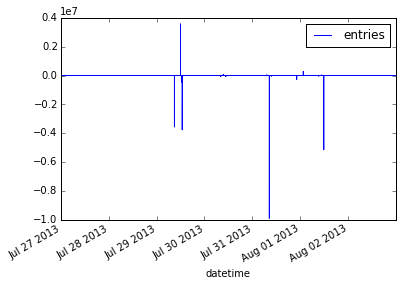

In [123]:
%matplotlib inline
df_pre_final_check.sort('datetime').plot(y='entries', x='datetime')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x15abee390>]], dtype=object)

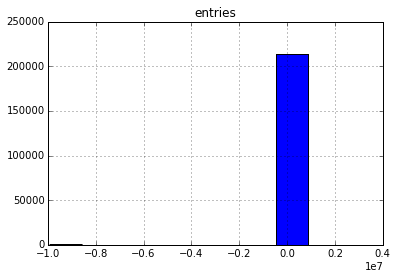

In [124]:
df_pre_final_check.hist(column='entries')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x14c1ebe50>]], dtype=object)

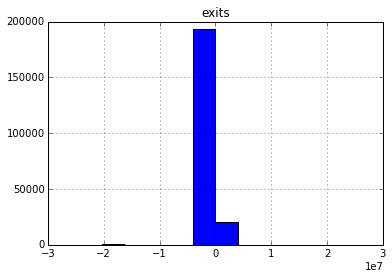

In [58]:
%matplotlib inline
df_pre_final_check.hist(column='exits')

In [59]:
df_pre_final_check.odometer_entries.max()

916848676

In [60]:
df_pre_final_check.loc[df.line_name == 'BD4'].odometer_entries.max()

7596941

Nope. Not necessarily due to some max odometer reading - we know this because the reading for `odometer_entries` goes up to `7596941`, well above `3771356`. Let's explore another to see if this is some thing that periodically occurs when a `door open` -> `door close` state aka `description`?

In [61]:
df_pre_final_check.loc[(df_pre_final_check.index >= 57220) & (df_pre_final_check.index <= 57235)]

,control_area,created_by_human,csv_row,date,description,division,interval,line_name,odometer_entries,odometer_exits,remote_unit,scp,station,datetime,entries,exits,net_time,net_flow
57220,N063A,False,7747,2013-07-31,REGULAR,IND,6,ACENQRS1237,9914139,2003997,R011,00-00-09,42 ST-PA BUS TE,2013-07-31 00:00:00,29,0,04:00:00,29
57221,N063A,False,7747,2013-07-31,REGULAR,IND,7,ACENQRS1237,9914151,2004001,R011,00-00-09,42 ST-PA BUS TE,2013-07-31 04:00:00,12,4,04:00:00,8
57222,N063A,False,7748,2013-07-31,DOOR OPEN,IND,0,ACENQRS1237,9914172,2004009,R011,00-00-09,42 ST-PA BUS TE,2013-07-31 07:07:24,21,8,03:07:24,13
57223,N063A,False,7748,2013-07-31,LOGON,IND,1,ACENQRS1237,1,7,R011,00-00-09,42 ST-PA BUS TE,2013-07-31 08:35:38,-9914171,-2004002,01:28:14,-7910169
57224,N063A,False,7748,2013-07-31,DOOR CLOSE,IND,2,ACENQRS1237,1,7,R011,00-00-09,42 ST-PA BUS TE,2013-07-31 08:36:06,0,0,00:00:28,0
57225,N063A,False,7748,2013-07-31,DOOR OPEN,IND,3,ACENQRS1237,1,7,R011,00-00-09,42 ST-PA BUS TE,2013-07-31 08:36:07,0,0,00:00:01,0
57226,N063A,False,7748,2013-07-31,LGF-MAN,IND,4,ACENQRS1237,1,7,R011,00-00-09,42 ST-PA BUS TE,2013-07-31 08:45:20,0,0,00:09:13,0
57227,N063A,False,7748,2013-07-31,DOOR CLOSE,IND,5,ACENQRS1237,1,7,R011,00-00-09,42 ST-PA BUS TE,2013-07-31 08:46:53,0,0,00:01:33,0
57228,N063A,False,7748,2013-07-31,REGULAR,IND,6,ACENQRS1237,466,48,R011,00-00-09,42 ST-PA BUS TE,2013-07-31 12:00:00,465,41,03:13:07,424
57229,N063A,False,7748,2013-07-31,REGULAR,IND,7,ACENQRS1237,668,78,R011,00-00-09,42 ST-PA BUS TE,2013-07-31 16:00:00,202,30,04:00:00,172


Appears that these states `Door Close`, `Door Open`, and `Logon` must be some admin activity which changes the odometer readings. While we may lose up to a few hours time, there is no way to recover this data unless we know more about these states and how an odometer is reset. Proceeding with setting these to 0...

In [62]:
df_pre_final_check.loc[df_pre_final_check.exits < 0].net_time

127772   5 days 02:17:16
76404    0 days 00:14:18
58575    0 days 00:20:57
104458   0 days 00:09:29
57223    0 days 01:28:14
207083   0 days 00:04:00
123674   3 days 00:14:30
123718   0 days 01:07:08
123730   0 days 00:03:03
124088   0 days 02:20:39
124094   0 days 02:42:11
124290   0 days 00:16:29
124303   0 days 01:15:23
121448   0 days 04:00:47
124594   0 days 00:51:58
Name: net_time, dtype: timedelta64[ns]

In [64]:
df = df_pre_final_check.copy(deep=True)
def replaceBadOdometerChanges(keys):
    ''' put into a function, the work to go thru the df was being repeated so this should be MUCH quicker '''
    
    where = []
    for i_key, key in enumerate(keys):
#         if i_key > 1:
#             break
        where.append(
            df[key] < 0
        )
    
    located = pd.concat(
        where,
        axis=1
    )
   
    located['replace'] = False
    for i_key, key in enumerate(keys):
        located['replace'] = located['replace'] | located[key]
    
    print(located.loc[located['replace']])
    
    for i_key, key in enumerate(keys):
        df.replace(
            df.loc[located['replace']][key].values,
            0,
            inplace=True
        )

replaceBadOdometerChanges(['exits', 'entries'])

df.describe()

        exits entries replace
127772   True    True    True
76404    True    True    True
58575    True    True    True
104458   True    True    True
57223    True    True    True
207083   True    True    True
123674   True    True    True
123718   True   False    True
123719  False    True    True
123730   True    True    True
124088   True    True    True
124094   True    True    True
124290   True    True    True
124303   True    True    True
121448   True    True    True
124594   True    True    True


,created_by_human,csv_row,interval,odometer_entries,odometer_exits,entries,exits,net_time,net_flow
count,217844,217844.000000,217844.000000,2.178440e+05,2.178440e+05,213368.000000,213368.000000,213368,213368.000000
mean,0.01787059,14722.286774,3.391932,5.600449e+06,3.309910e+06,175.492961,221.859515,0 days 03:25:59.023147,-8.242632
std,0.1324814,8490.095194,2.296694,3.551615e+07,3.494169e+07,7764.413448,43828.481602,0 days 01:23:09.833265,54001.990665
min,False,0.000000,0.000000,-9.314769e+08,-8.786480e+08,0.000000,0.000000,0 days 00:00:00,-16669040.000000
25%,0,7363.000000,1.000000,3.454710e+05,2.033342e+05,3.000000,2.000000,0 days 04:00:00,-14.000000
50%,0,14722.000000,3.000000,2.027753e+06,1.233320e+06,56.000000,40.000000,0 days 04:00:00,0.000000
75%,0,22060.000000,5.000000,5.163563e+06,3.670348e+06,213.000000,148.000000,0 days 04:00:00,76.000000
max,True,29426.000000,7.000000,9.168487e+08,8.624322e+08,3572935.000000,20241975.000000,5 days 02:17:16,16668372.000000


In [65]:
df.loc[df.entries < 0].entries.values

array([], dtype=float64)

In [66]:
df['cummulative_flow'] = df.entries + df.exits

In [67]:
df.to_csv('data/reduced.csv')

In [68]:
df.describe()

,created_by_human,csv_row,interval,odometer_entries,odometer_exits,entries,exits,net_time,net_flow,cummulative_flow
count,217844,217844.000000,217844.000000,2.178440e+05,2.178440e+05,213368.000000,213368.000000,213368,213368.000000,213368.000000
mean,0.01787059,14722.286774,3.391932,5.600449e+06,3.309910e+06,175.492961,221.859515,0 days 03:25:59.023147,-8.242632,397.352476
std,0.1324814,8490.095194,2.296694,3.551615e+07,3.494169e+07,7764.413448,43828.481602,0 days 01:23:09.833265,54001.990665,51569.580366
min,False,0.000000,0.000000,-9.314769e+08,-8.786480e+08,0.000000,0.000000,0 days 00:00:00,-16669040.000000,0.000000
25%,0,7363.000000,1.000000,3.454710e+05,2.033342e+05,3.000000,2.000000,0 days 04:00:00,-14.000000,11.000000
50%,0,14722.000000,3.000000,2.027753e+06,1.233320e+06,56.000000,40.000000,0 days 04:00:00,0.000000,134.000000
75%,0,22060.000000,5.000000,5.163563e+06,3.670348e+06,213.000000,148.000000,0 days 04:00:00,76.000000,408.000000
max,True,29426.000000,7.000000,9.168487e+08,8.624322e+08,3572935.000000,20241975.000000,5 days 02:17:16,16668372.000000,23814910.000000


# Sanity Check Analysis


## Why

I started at ITG 2 weeks before the SEC issue came out. My first project was retrieving the client data from 2010 - 2011, delivering it, running analysis, benchmarking, etc on it. One large issue, (ignoring the high stress and that I was very new to the DB configurations) was that the data was known to be incorrect in certain ways. I quickly learned that the best thing when working on a foreign data set is to do a bit of sanity checking before delivery to a manager, client, etc. Thankfully I didn't make any mistakes or large assumptions during the SEC issue and as such I now perform some checks before I being playing with the data.

## Initial Thoughts

Why would there be so many more `entries` than `exits`? Guessing some of that is due to technical error? Probably the fact that there are the large (usually black) emergency doors which users exit from when there is a large amount of foot traffic at any given time. About a year ago I can recall reading an article [here](http://www.nytimes.com/2015/01/01/nyregion/exit-alarms-in-the-subways-are-silenced-by-the-mta.html) that states that the MTA is slowly removing the alarm for these doors, so I would hypothesize one way to confirm this would be to calculate the divergence between entries and exits over time, especially with newer data and at peak hours. The divergence should increase if this is the case. Something to look into once I start on refactoring the above to work on N files and then the site.

`net_time` seems good, mostly because the mean value is ~3hours and 25 min, just short of the 4 hour REGULAR interval. The maintnance or other events shouldn't be too large, so this is acceptable since they lower the mean difference.

## Check for abnormally large data

We saw some negatives due to (unknown) error, so check if it went in the opposite direction ever... Looking for extreme tails. Could blindly use quartiles to auto reject, but then may be getting rid of important data...

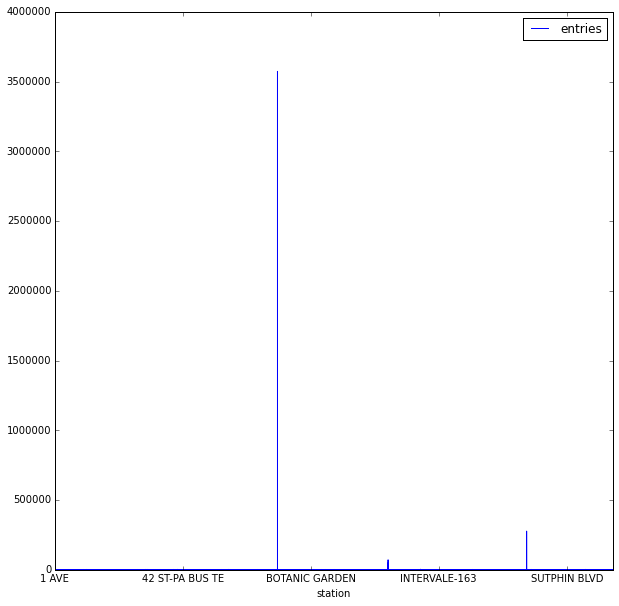

In [69]:
%matplotlib inline

df.plot(y='entries', x='station', figsize=(10,10))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x14a43d910>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x139ec1490>]], dtype=object)

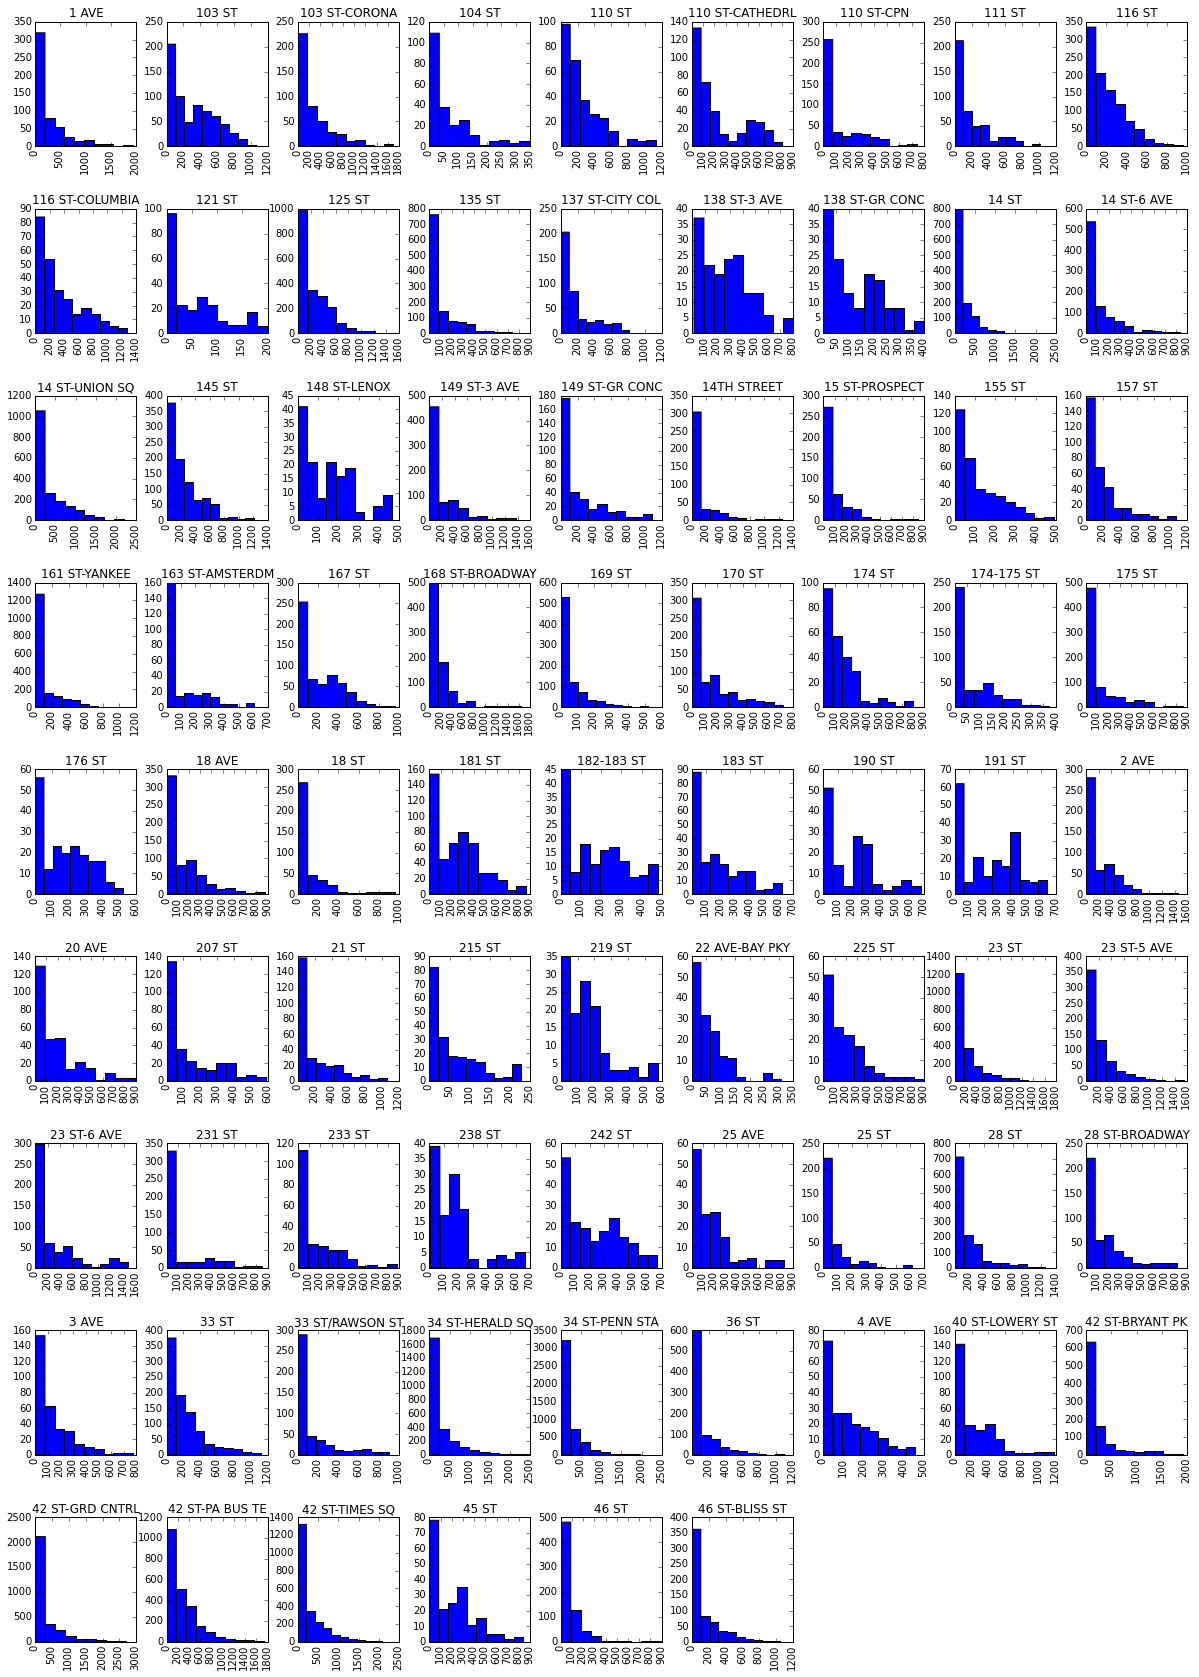

In [70]:
df.sort('station')[0:len(df) / 4].hist(column='entries', by='station', figsize=(20,30))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1436dc750>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x155ff1750>]], dtype=object)

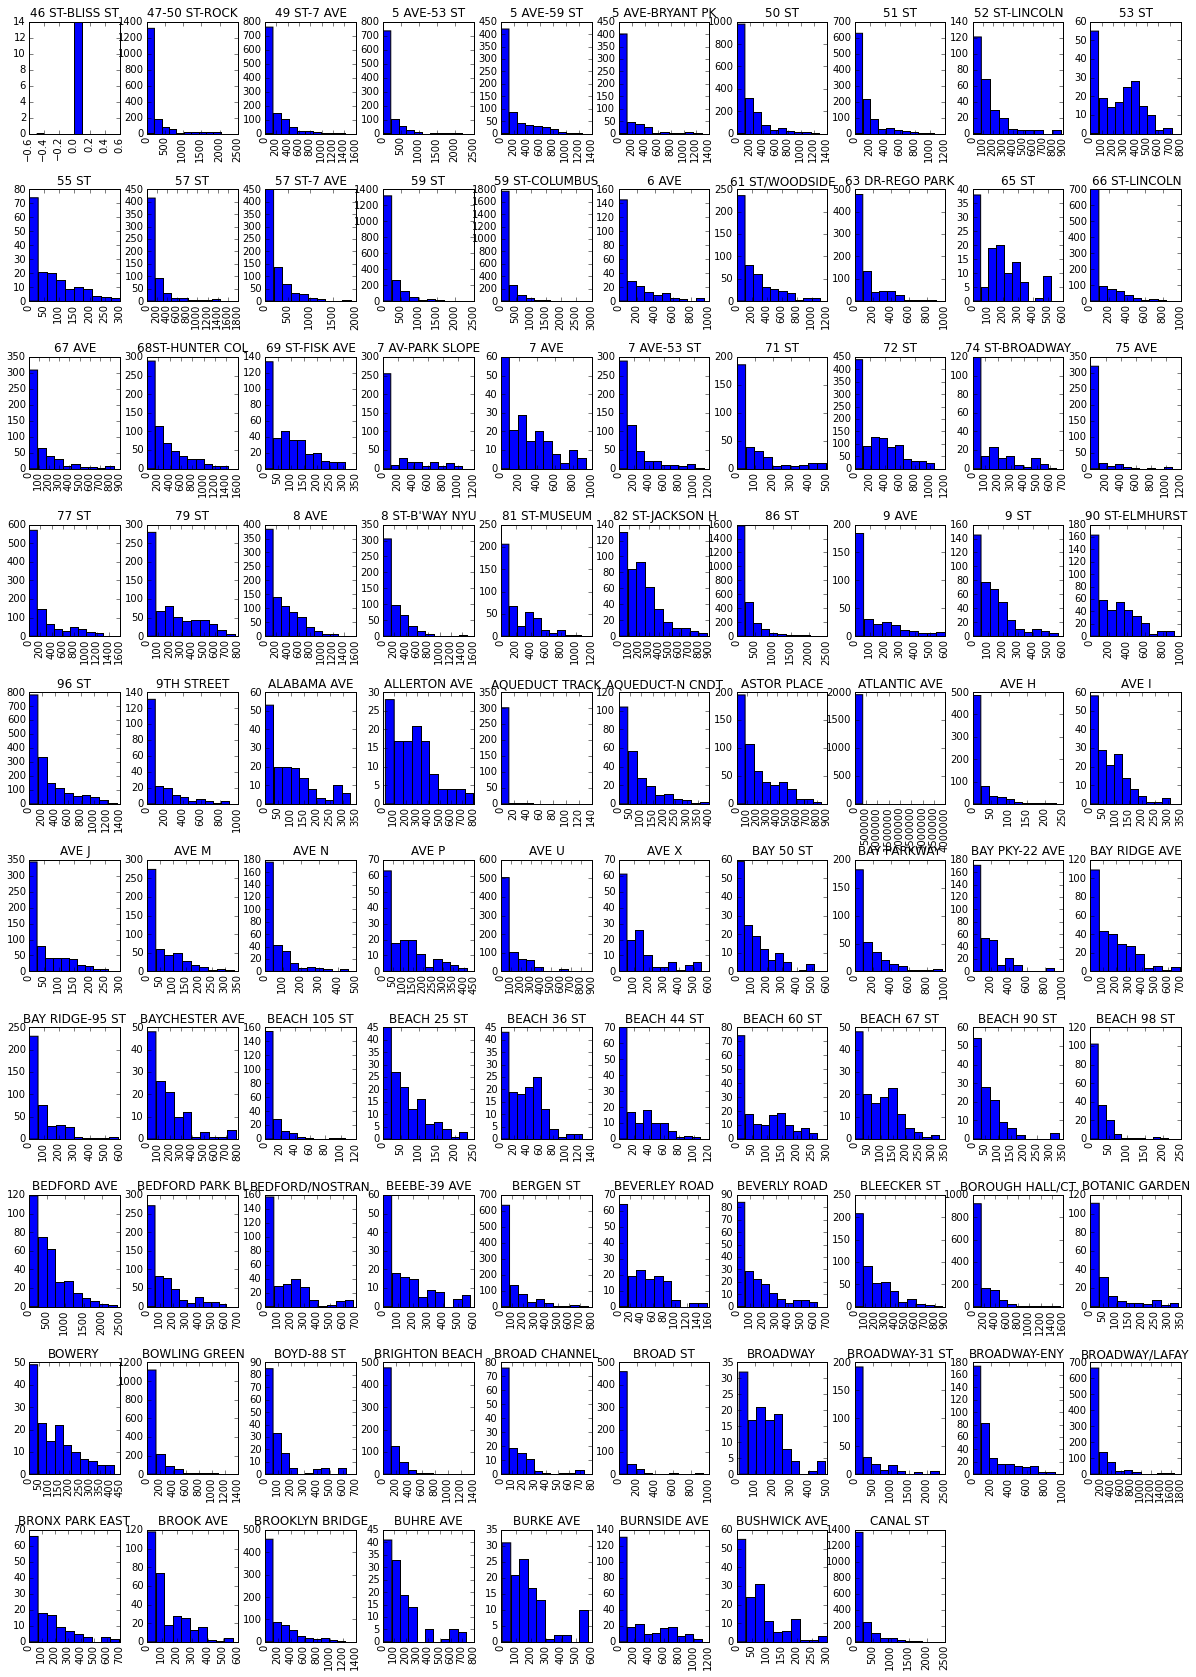

In [71]:
df.sort('station')[len(df) / 4: len(df) / 2].hist(column='entries', by='station', figsize=(20,30))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1570cce50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x15b05fa10>]], dtype=object)

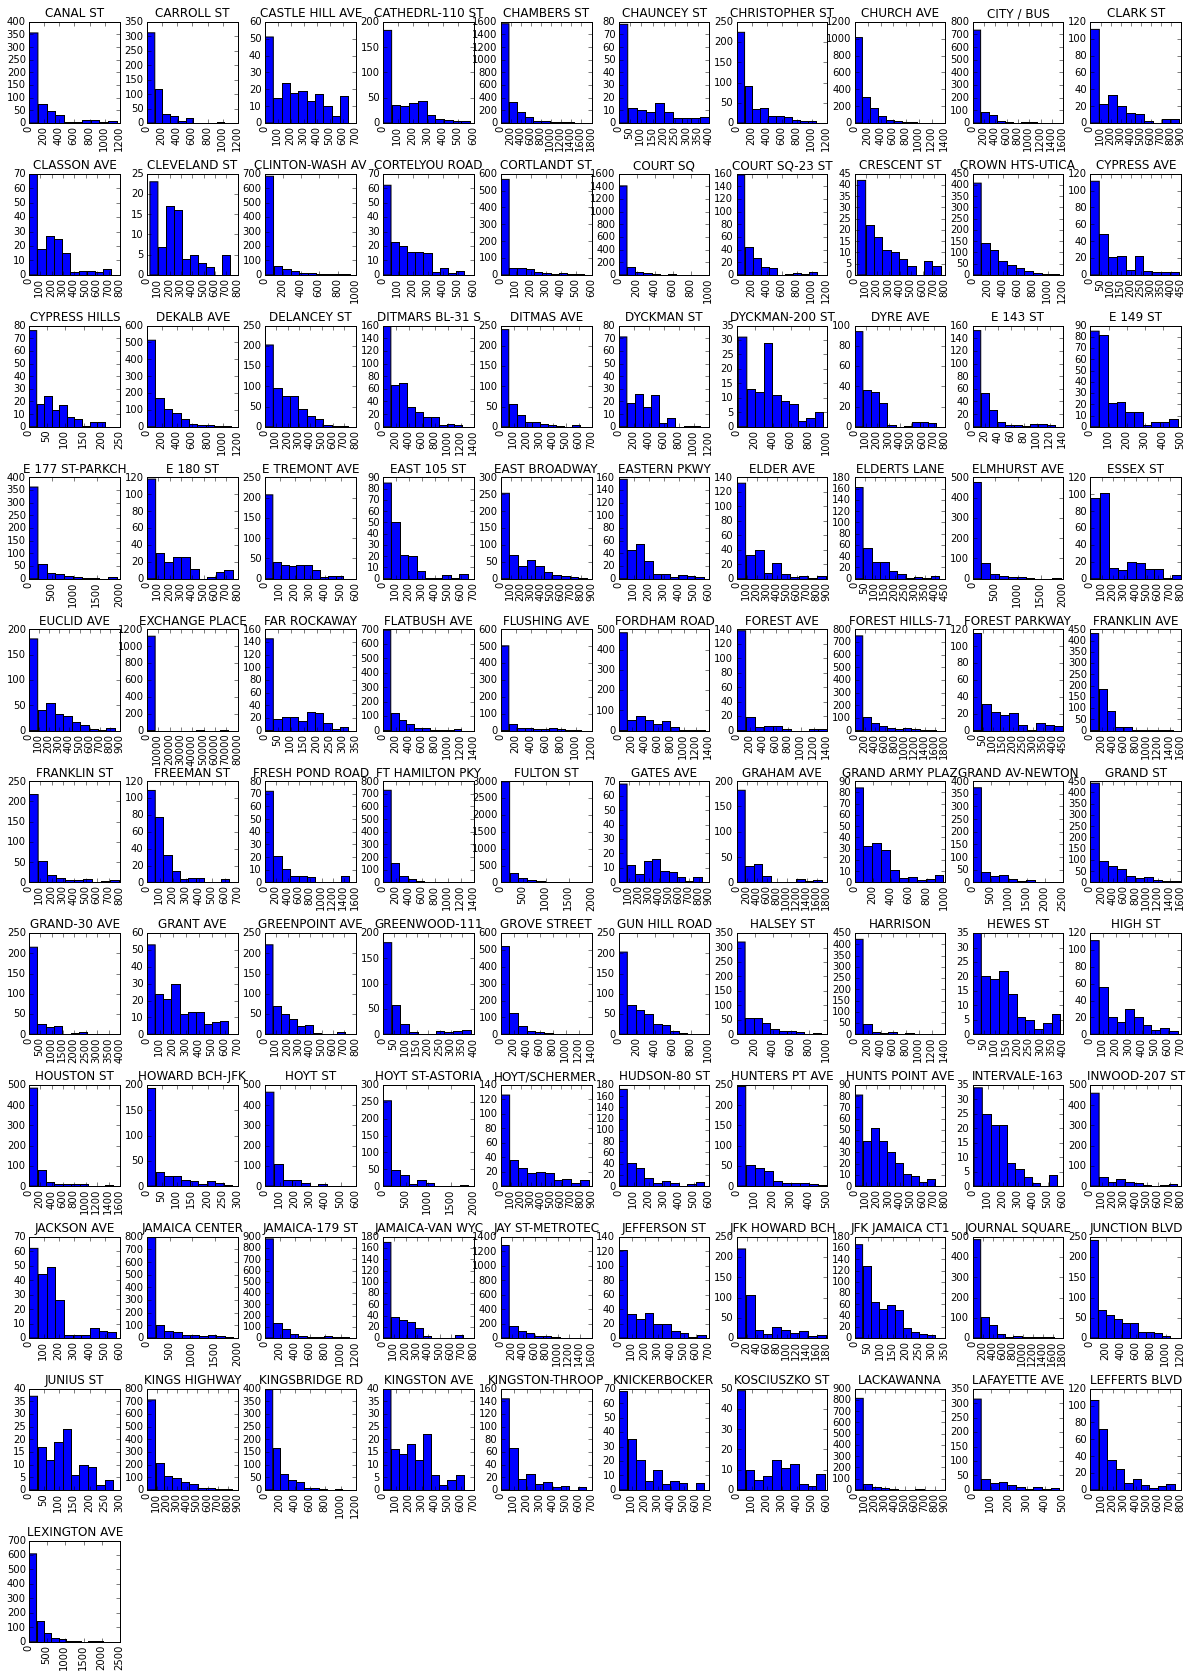

In [79]:
df.sort('station')[len(df) / 2: len(df) / 4 * 3].hist(column='entries', by='station', figsize=(20,30))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x15b258cd0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x161c1da10>]], dtype=object)

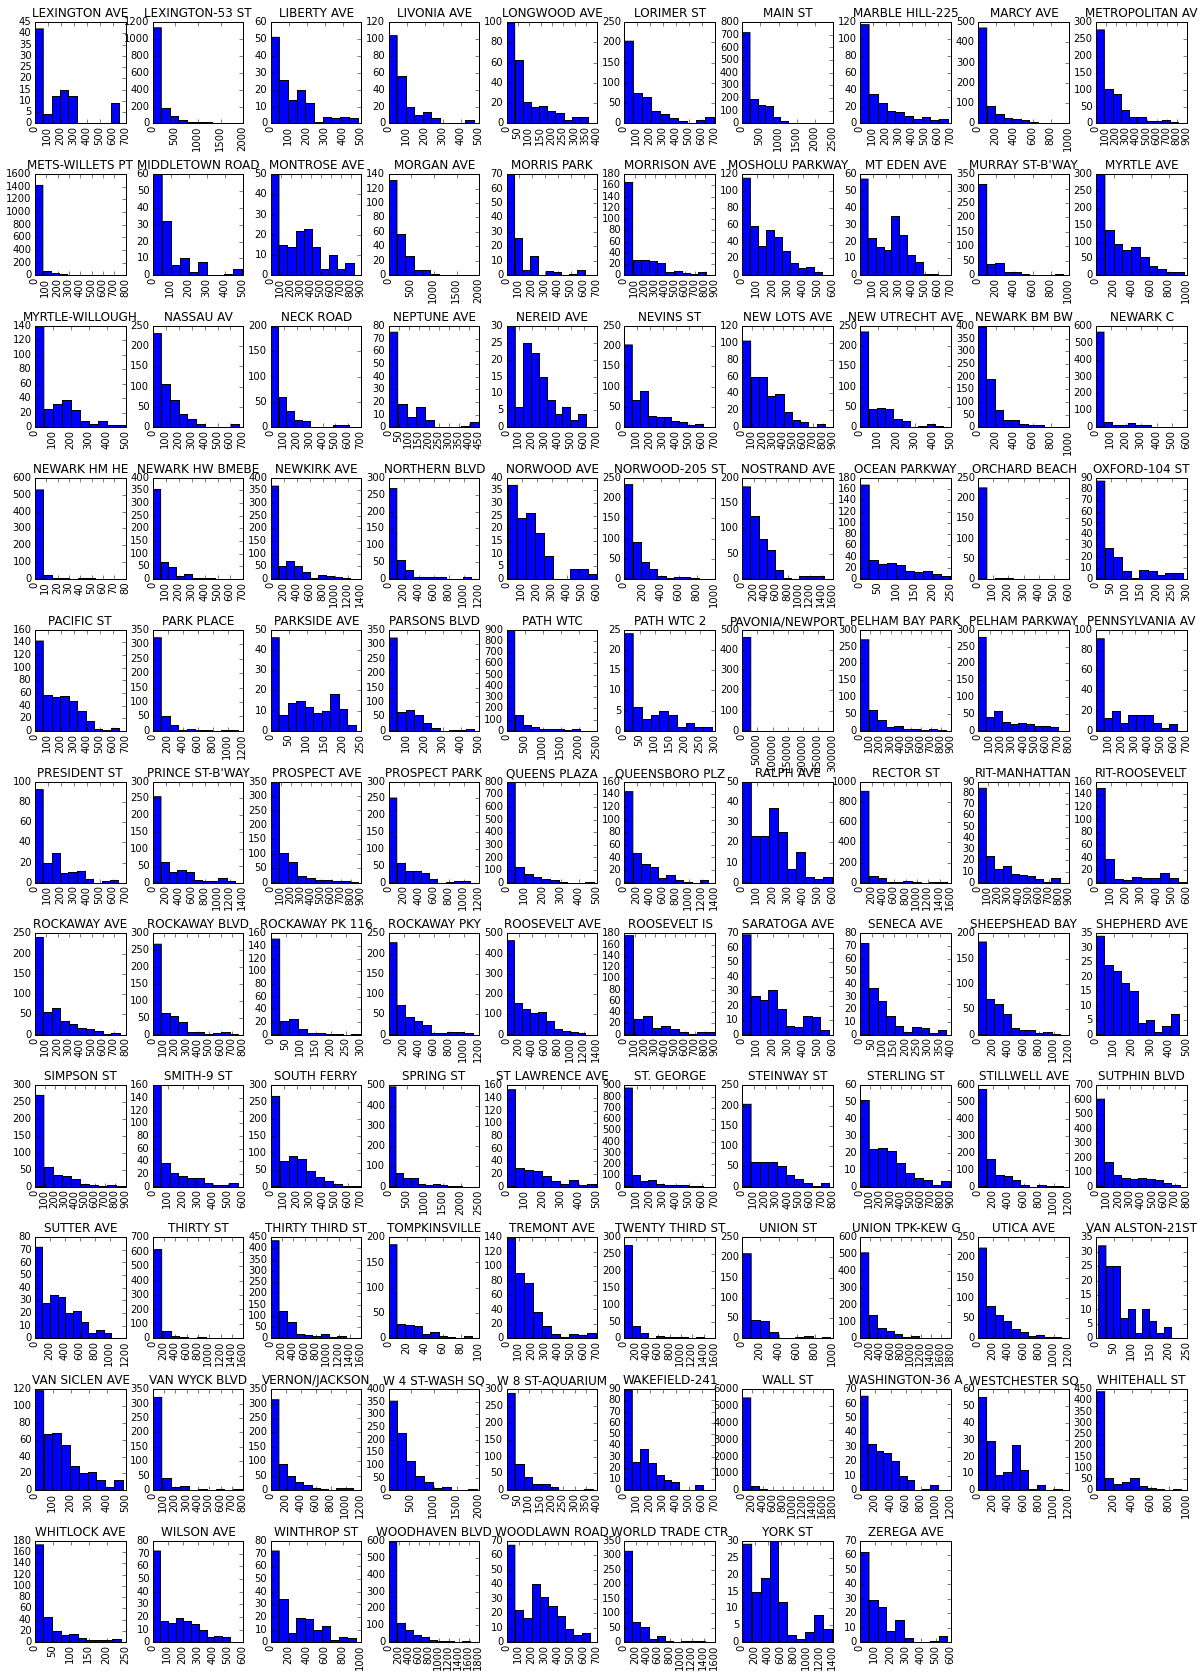

In [80]:
df.sort('station')[len(df) / 4 * 3: len(df)].hist(column='entries', by='station', figsize=(20,30))

In [81]:
by_station = []
for i, (station, data) in enumerate(df.groupby('station')):
    by_station.append({
        'station': station,
        'entries': data.entries.sum(),
        'exits': data.exits.sum(),
    })
by_station = pd.DataFrame(by_station)
by_station = by_station.sort(
    ['entries', 'station'],
    ascending=False
).reset_index(drop=True)

by_station.head()

,entries,exits,station
0,3746157,20385264,ATLANTIC AVE
1,1016926,896321,34 ST-PENN STA
2,865104,817513,42 ST-GRD CNTRL
3,716378,670892,34 ST-HERALD SQ
4,642932,583821,14 ST-UNION SQ


In [82]:
df[df['station'] == 'ATLANTIC AVE'][['scp', 'datetime', 'odometer_entries', 'entries', 'odometer_exits', 'exits']].sort('datetime')

,scp,datetime,odometer_entries,entries,odometer_exits,exits
207053,00-03-00,2013-07-27 00:00:00,3933858,NaN,20322401,NaN
208060,00-06-05,2013-07-27 00:00:00,890359,NaN,269436,NaN
208104,01-00-00,2013-07-27 00:00:00,17955,NaN,6526,NaN
207585,00-04-02,2013-07-27 00:00:00,317211,NaN,187443,NaN
208638,01-03-04,2013-07-27 00:00:00,24396,NaN,19560,NaN
208152,01-00-01,2013-07-27 00:00:00,52222,NaN,19761,NaN
208201,01-00-02,2013-07-27 00:00:00,78542,NaN,30897,NaN
208687,01-03-05,2013-07-27 00:00:00,288957,NaN,216504,NaN
207542,00-04-01,2013-07-27 00:00:00,921746,NaN,554819,NaN
208248,01-00-03,2013-07-27 00:00:00,107952,NaN,49111,NaN


In [83]:
by_scp = []
for i, (scp, data) in enumerate(df[df['station'] == 'ATLANTIC AVE'].groupby('scp')):
    by_scp.append({
        'scp': scp,
        'entries': data.entries.sum(),
        'exits': data.exits.sum(),
    })
by_scp = pd.DataFrame(by_scp)
by_scp = by_scp.sort(
    ['entries', 'scp'],
    ascending=False
).reset_index(drop=True)

by_scp.head()

,entries,exits,scp
0,3576405,20280601,00-03-00
1,15545,1530,00-03-06
2,14747,1251,00-03-05
3,14051,2637,00-03-07
4,13176,1587,00-03-04


In [84]:
df[df['scp'] == '00-03-00'][['scp', 'entries', 'datetime', 'csv_row']].sort('entries', ascending=False).head()

,scp,entries,datetime,csv_row
207099,00-03-00,3572935,2013-07-29 12:00:00,27980
195793,00-03-00,3669,2013-07-30 12:00:00,26453
195788,00-03-00,2381,2013-07-29 12:00:00,26453
195800,00-03-00,2373,2013-07-31 12:00:00,26454
195495,00-03-00,2324,2013-07-30 12:00:00,26415


In [85]:
df[(df['csv_row'] >= 27979 )& (df['csv_row'] <= 27981)][['csv_row', 'description', 'scp', 'station', 'odometer_entries', 'entries', 'odometer_exits', 'exits', 'datetime']]

,csv_row,description,scp,station,odometer_entries,entries,odometer_exits,exits,datetime
207085,27979,DOOR CLOSE,00-03-00,ATLANTIC AVE,361895,0,88668,0,2013-07-29 08:59:05
207086,27979,DOOR OPEN,00-03-00,ATLANTIC AVE,361895,0,88668,0,2013-07-29 08:59:06
207087,27979,DOOR CLOSE,00-03-00,ATLANTIC AVE,361895,0,88668,0,2013-07-29 08:59:08
207088,27979,DOOR OPEN,00-03-00,ATLANTIC AVE,361895,0,88668,0,2013-07-29 08:59:09
207089,27979,DOOR CLOSE,00-03-00,ATLANTIC AVE,361895,0,88668,0,2013-07-29 08:59:10
207090,27979,DOOR OPEN,00-03-00,ATLANTIC AVE,361895,0,88668,0,2013-07-29 08:59:11
207091,27979,DOOR CLOSE,00-03-00,ATLANTIC AVE,361895,0,88668,0,2013-07-29 08:59:14
207092,27979,DOOR OPEN,00-03-00,ATLANTIC AVE,361895,0,88668,0,2013-07-29 08:59:18
207093,27980,DOOR CLOSE,00-03-00,ATLANTIC AVE,361895,0,88668,0,2013-07-29 08:59:34
207094,27980,DOOR OPEN,00-03-00,ATLANTIC AVE,361895,0,88668,0,2013-07-29 08:59:39


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x161eb5850>]], dtype=object)

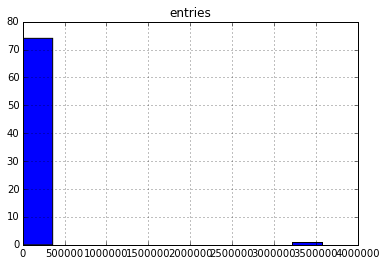

In [86]:
df[(df.scp == '00-03-00') & (df.station == 'ATLANTIC AVE')].hist(column='entries')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x16422bfd0>]], dtype=object)

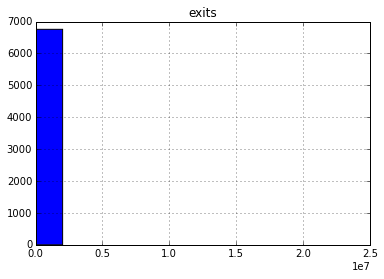

In [87]:
df[df['scp'] == '00-03-00'].hist(column='exits')

## Errors in CSV...

The above csv_row `27980` clearly has a mistake between the DOOR OPEN and then REGULAR events. I propose setting it to zero in the meantime. High right skew

In [93]:
df.loc[(df.csv_row == 27980) & (df.entries == 3572935)]

,control_area,created_by_human,csv_row,date,description,division,interval,line_name,odometer_entries,odometer_exits,remote_unit,scp,station,datetime,entries,exits,net_time,net_flow,cummulative_flow,manually_corrected


In [94]:
df['manually_corrected'] = False

In [95]:
df.set_value(207099, 'entries', 0)
df.set_value(207099, 'exits', 0)

,control_area,created_by_human,csv_row,date,description,division,interval,line_name,odometer_entries,odometer_exits,remote_unit,scp,station,datetime,entries,exits,net_time,net_flow,cummulative_flow,manually_corrected
33892,H007,False,4589,2013-07-27,REGULAR,BMT,0,L,7195364,7829818,R248,00-00-00,1 AVE,2013-07-27 00:00:00,NaN,NaN,NaT,NaN,NaN,False
33893,H007,False,4589,2013-07-27,REGULAR,BMT,1,L,7195524,7830214,R248,00-00-00,1 AVE,2013-07-27 04:00:00,160,396,04:00:00,-236,556,False
33894,H007,False,4589,2013-07-27,RECOVR AUD,BMT,2,L,7195524,7830214,R248,00-00-00,1 AVE,2013-07-27 04:00:00,0,0,00:00:00,0,0,False
33895,H007,False,4589,2013-07-27,REGULAR,BMT,3,L,7195645,7830530,R248,00-00-00,1 AVE,2013-07-27 08:00:00,121,316,04:00:00,-195,437,False
33896,H007,False,4589,2013-07-27,REGULAR,BMT,4,L,7196191,7831224,R248,00-00-00,1 AVE,2013-07-27 12:00:00,546,694,04:00:00,-148,1240,False
33897,H007,False,4589,2013-07-27,REGULAR,BMT,5,L,7196942,7832130,R248,00-00-00,1 AVE,2013-07-27 16:00:00,751,906,04:00:00,-155,1657,False
33898,H007,False,4589,2013-07-27,REGULAR,BMT,6,L,7197650,7833267,R248,00-00-00,1 AVE,2013-07-27 20:00:00,708,1137,04:00:00,-429,1845,False
33899,H007,False,4589,2013-07-28,REGULAR,BMT,7,L,7198087,7834356,R248,00-00-00,1 AVE,2013-07-28 00:00:00,437,1089,04:00:00,-652,1526,False
33900,H007,False,4590,2013-07-28,REGULAR,BMT,0,L,7198269,7834852,R248,00-00-00,1 AVE,2013-07-28 04:00:00,182,496,04:00:00,-314,678,False
33901,H007,False,4590,2013-07-28,RECOVR AUD,BMT,1,L,7198269,7834852,R248,00-00-00,1 AVE,2013-07-28 04:00:00,0,0,00:00:00,0,0,False


In [97]:
by_scp = []
for i, (scp, data) in enumerate(df[df.station == 'ATLANTIC AVE'].groupby('scp')):
    by_scp.append({
        'scp': scp,
        'entries': data.entries.sum(),
        'exits': data.exits.sum(),
    })
by_scp = pd.DataFrame(by_scp)
by_scp = by_scp.sort(
    ['entries', 'scp'],
    ascending=False
).reset_index(drop=True)

by_scp.head()

,entries,exits,scp
0,15545,1530,00-03-06
1,14747,1251,00-03-05
2,14051,2637,00-03-07
3,13176,1587,00-03-04
4,10517,3710,00-03-03


In [98]:
by_scp = by_scp.sort(
    ['exits', 'scp'],
    ascending=False
).reset_index(drop=True)

by_scp.head()

,entries,exits,scp
0,3470,38626,00-03-00
1,5668,22690,00-03-01
2,8481,9747,00-03-02
3,3805,5651,00-04-05
4,6828,4843,01-03-05


## Investigate `Exits` for scp

00-03-00 and 	00-03-01 look a little big in comparison, be sure

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1632a9ed0>]], dtype=object)

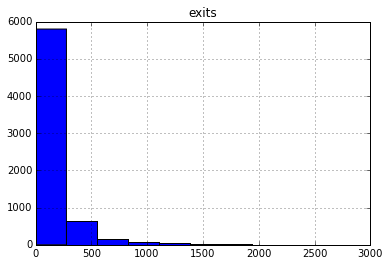

In [99]:
df[df.scp == '00-03-00'].hist(column='exits')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x164e1eb50>]], dtype=object)

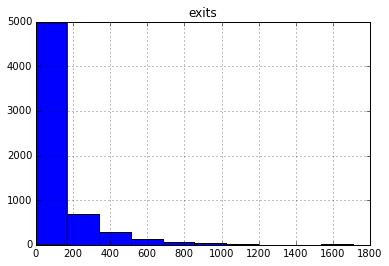

In [100]:
df[df.scp == '00-03-01'].hist(column='exits')

In [104]:
df[(df.scp == '00-03-01') & (df.station == 'ATLANTIC AVE')][['csv_row', 'exits', 'station', 'datetime']].sort('exits', ascending=False)

,csv_row,exits,station,datetime
207176,27990,1708,ATLANTIC AVE,2013-08-01 20:00:00
207162,27989,1645,ATLANTIC AVE,2013-07-30 20:00:00
207182,27991,1621,ATLANTIC AVE,2013-08-02 20:00:00
207169,27990,1594,ATLANTIC AVE,2013-07-31 20:00:00
207155,27988,1525,ATLANTIC AVE,2013-07-29 20:00:00
207181,27991,963,ATLANTIC AVE,2013-08-02 16:00:00
207175,27990,874,ATLANTIC AVE,2013-08-01 16:00:00
207161,27989,869,ATLANTIC AVE,2013-07-30 16:00:00
207134,27985,801,ATLANTIC AVE,2013-07-27 20:00:00
207133,27985,776,ATLANTIC AVE,2013-07-27 16:00:00


# Data Analysis

## 1. What is the total number of entries & exits across the subway system for August 1, 2013?


In [106]:
august_1_2013 = df.loc[df.date == datetime(2013, 8, 1)]

# august_1_2013.to_csv('august1st.csv')

august_1_total_traffic = pd.Series({
    'exits': august_1_2013.exits.sum(),
    'entries': august_1_2013.entries.sum()
})
august_1_total_traffic['total'] = august_1_total_traffic.sum()

print(august_1_total_traffic)

print(august_1_2013.cummulative_flow.sum())

entries     5922368
exits       4588930
total      10511298
dtype: float64
10511298.0


## Analysis 1

According to the [Subway Ridership at a Glance](http://web.mta.info/nyct/facts/ridership/), I am roughly hitting the average, if the MTA is calculating ridership as a function of entries only. August 1st, 2013 was a Thursay, so there is weekday commmuting traffic in addition to the beginning of late night activities for many people. My number is a little high, but not that far off, as it is the summer and there could be a larger number of people vacationing in NYC at the time.

( computed - MTA reported avg for year ) / (MTA reported avg for year)

( 5922368 - 5465034 ) / 5465034 = ~0.084 or 8.4% error from the known avg for the year

In [134]:
august_1st_by_time = {}


for (station, datetime), data in august_1_2013.groupby(['station', 'datetime']):

    if station not in august_1st_by_time:
        august_1st_by_time[station] = {}
    
    august_1st_by_time[station][datetime] = data.entries.sum() - data.exits.sum()

august_1st_by_time = pd.DataFrame(august_1st_by_time)
august_1st_by_time.head()

,1 AVE,103 ST,103 ST-CORONA,104 ST,110 ST,110 ST-CATHEDRL,110 ST-CPN,111 ST,116 ST,116 ST-COLUMBIA,...,WESTCHESTER SQ,WHITEHALL ST,WHITLOCK AVE,WILSON AVE,WINTHROP ST,WOODHAVEN BLVD,WOODLAWN ROAD,WORLD TRADE CTR,YORK ST,ZEREGA AVE
2013-08-01 00:00:00,43,NaN,-1651,-275,-738,NaN,-778,-1566,NaN,NaN,...,-331,NaN,-181,-422,NaN,-42,401,682,NaN,NaN
2013-08-01 00:00:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-08-01 00:00:13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-08-01 00:00:25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-08-01 00:02:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


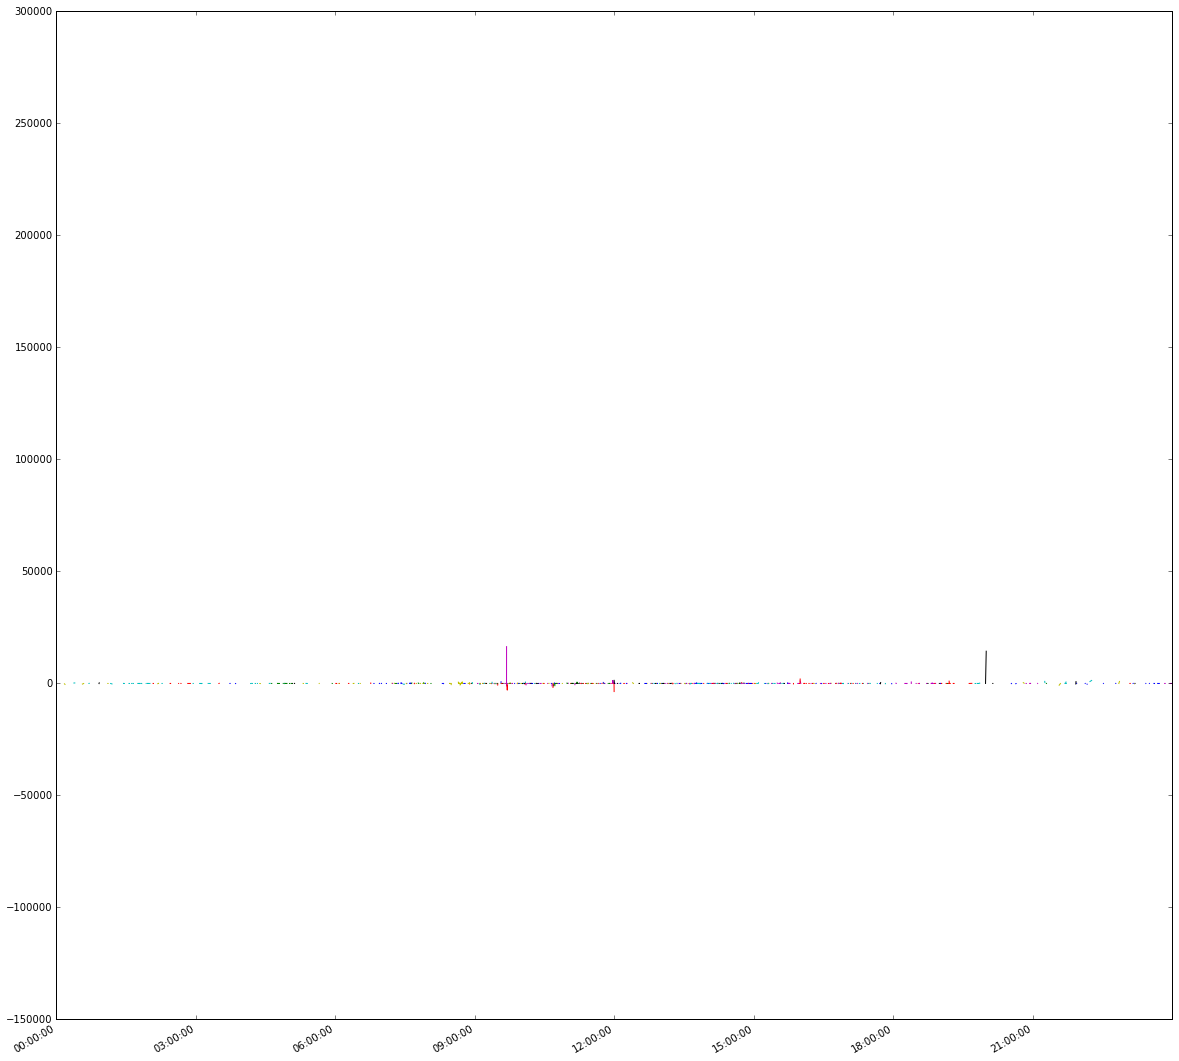

In [137]:
august_1st_by_time.plot(figsize=(20,20), legend=False)

## Continued Analysis of 1

We see a large cluster at ~9 AM and then again in the evening. This is about when people commute to and from work, so we have some info as to why this divergence occcurs between entries and exits.

## 2. Let’s define the busy-ness as sum of entry & exit count. What station was the busiest on August 1, 2013? What turnstile was the busiest on that date?

### 2.1 What station was the busiest on August 1, 2013?

In [107]:
df_by_station = august_1_2013.groupby('station')

station_by_usage = []
for (i_station, (station, data)) in enumerate(df_by_station):
#     if i_station > 2:
#         break
    
    station_by_usage.append({
        'station': station,
        'cummulative_flow': data.cummulative_flow.sum()
    })

station_by_usage = pd.DataFrame(station_by_usage)
station_by_usage = station_by_usage.sort(
    ['cummulative_flow', 'station'],
    ascending=False
).reset_index(drop=True)
station_by_usage.head()

,cummulative_flow,station
0,338804,PAVONIA/NEWPORT
1,332402,34 ST-PENN STA
2,315928,42 ST-GRD CNTRL
3,219081,34 ST-HERALD SQ
4,215380,EXCHANGE PLACE


### Analysis 2.1

The above analysis reports that Pavonia / Newport station is the busiest station on August 1, 2013. This makes sense because this station is a major commuting hub, with the following connections (according to wikipedia):

- NJT Bus NJT Bus: 64, 68, and 126
- NJT Bus Academy Bus: Westampton, Lincroft/Red Bank lines
- NJT Bus Red & Tan in Hudson County: 16 (above connections on Washington Boulevard)
- NJT Bus Red & Tan in Hudson County: 4, 16
- NJT Bus A&C Bus (inside Newport Centre Mall)
- PATH at Newport

This trend is found accross the top 5 stations, as each are major commuting hubs for different lines and means of transportation: e.g. `Penn station` also has NJ transit and `42nd St` connects to the bus terminal. `Exchange Place` has it in the name.

I am unfamiliar with NJ transportation, but according to this Map, `PAVONIA/NEWPORT` is probably a majory artery for people commuting to and from NJ.

![map](http://www.hgk.com/wp-content/uploads/2014/07/path_map.png)

### 2.2 What turnstile was the busiest on that date?

In [108]:
df_by_station = august_1_2013.groupby(['station', 'scp'])

scp_by_usage = []
for (i_station, ((station, scp), data)) in enumerate(df_by_station):
#     if i_station > 2:
#         break
    
    scp_by_usage.append({
        'scp': scp,
        'station': station,
        'cummulative_flow': data.cummulative_flow.sum()
    })

scp_by_usage = pd.DataFrame(scp_by_usage)
scp_by_usage = scp_by_usage.sort(
    ['cummulative_flow', 'scp', 'station'],
    ascending=False
).reset_index(drop=True)
scp_by_usage[0:10]

,cummulative_flow,scp,station
0,303459,00-00-01,PAVONIA/NEWPORT
1,133520,00-01-00,EXCHANGE PLACE
2,49188,00-04-00,EXCHANGE PLACE
3,35956,00-00-00,42 ST-GRD CNTRL
4,30232,00-00-01,42 ST-GRD CNTRL
5,22210,00-03-00,42 ST-GRD CNTRL
6,21123,00-03-03,42 ST-GRD CNTRL
7,20502,00-03-04,42 ST-GRD CNTRL
8,20002,00-00-00,34 ST-PENN STA
9,19824,00-00-00,125 ST


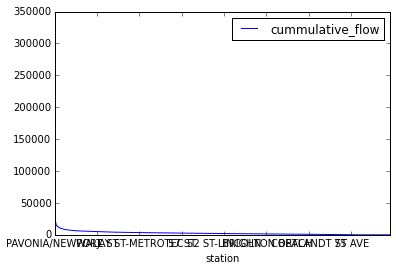

In [114]:
scp_by_usage.plot(y='cummulative_flow', x='station')

### Analysis of 2.2

This data is quite consistent with the findings of `Analysis 2.1`. Turnstile `00-00-01` was the busiest, which also was at `PAVONIA/NEWPORT`. I find it fascinating (below) that it appears a vast majority of people use only a single turnstile. The other turnstiles for `PAVONIA/NEWPORT` are several std deviations away... It must be really convenient! No probably just an onflow of people always entering thru the same one, but will see below

In [115]:
scp_by_usage[scp_by_usage.station == 'PAVONIA/NEWPORT']

,cummulative_flow,scp,station
0,303459,00-00-01,PAVONIA/NEWPORT
531,4731,00-00-00,PAVONIA/NEWPORT
660,4258,00-00-06,PAVONIA/NEWPORT
690,4178,00-00-05,PAVONIA/NEWPORT
933,3614,00-00-03,PAVONIA/NEWPORT
1013,3430,00-00-02,PAVONIA/NEWPORT
1040,3396,00-00-04,PAVONIA/NEWPORT
1099,3309,00-00-07,PAVONIA/NEWPORT
1302,2939,00-00-08,PAVONIA/NEWPORT
1373,2845,00-00-0A,PAVONIA/NEWPORT


In [116]:
scp_by_usage_independent = []
for (i_station, ((station, scp), data)) in enumerate(df_by_station):
#     if i_station > 2:
#         break
    
    scp_by_usage_independent.append({
        'scp': scp,
        'station': station,
        'entries': data.entries.sum(),
        'exits': data.exits.sum(),
        'cummulative_flow': data.cummulative_flow.sum()
    })
scp_by_usage_independent = pd.DataFrame(scp_by_usage_independent)
scp_by_usage_independent = scp_by_usage_independent.sort(
    ['cummulative_flow', 'scp', 'station'],
    ascending=False
).reset_index(drop=True)
scp_by_usage_independent[0:10]

,cummulative_flow,entries,exits,scp,station
0,303459,280665,22794,00-00-01,PAVONIA/NEWPORT
1,133520,1414,132106,00-01-00,EXCHANGE PLACE
2,49188,44769,4419,00-04-00,EXCHANGE PLACE
3,35956,10890,25066,00-00-00,42 ST-GRD CNTRL
4,30232,13219,17013,00-00-01,42 ST-GRD CNTRL
5,22210,8120,14090,00-03-00,42 ST-GRD CNTRL
6,21123,9162,11961,00-03-03,42 ST-GRD CNTRL
7,20502,10033,10469,00-03-04,42 ST-GRD CNTRL
8,20002,9370,10632,00-00-00,34 ST-PENN STA
9,19824,10189,9635,00-00-00,125 ST


### Continued Analysis of 2.2

This pretty much confirms what we all see during rush hour on the MTA, where there are too many people going in a single direction so we self optimize and wait in a line with other people going in the same direction as us. Certain turnstiles are largely used for `entries` and others for `exits`.  As are the cases in `EXCHANGE PLACE` where `00-01-00` is used mostly for exits and `00-04-00` mosty for entries